# Deep Neural Image Captioning useful in Devices for Visually Impaired, using CNN (VGG-16 Net) as Feature Extractor & LSTM for sentence generation (Transfer Learning)
## 1. Importing Relevant Libraries

In [1]:
import os
import time
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter 
from keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")

## 2. Importing Flickr8k Dataset

In [2]:
Flickr_text_dir = "../input/flickr8k-sau/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
Flickr_jpg_dir = "../input/flickr8k-sau/flickr8k-sau/Flickr_Data/Images"
jpgs = os.listdir(Flickr_jpg_dir)  # os.listdir(path) returns list containing names of entries in directory given by path.
print("Number of .jpg flies in Flicker8k Dataset: {}".format(len(jpgs)))

Number of .jpg flies in Flicker8k Dataset: 8091


## 3. Data Analysis
### Loading the Text Data from the Flickr8k Dataset and saving it to a panda Dataframe 'df_txt_flickr'.

In [3]:
def load_csv(directory):
    desc = dict()
    text = pd.read_csv(directory, delimiter = '|', header = None, names = ["filename","index","caption"])
    text = text.iloc[1:,:]
    df_new = text[text.iloc[:,2].notnull()]
    print(df_new.iloc[:5,:])
    return df_new

In [4]:
file = open(Flickr_text_dir,'r') # Opening File
text = file.read() # Reading File
file.close() # Closing File
datatxt = []
for line in text.split('\n'): # Loop runs for No. of Images present
    col = line.split('\t') # Splits into 2 tuples on basis of '\t'
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splits 1st tuple on basis of '#'
    datatxt.append(w + [col[1].lower()])
df_txt_flickr = pd.DataFrame(datatxt,columns=["filename","index","caption"])
uni_filenames = np.unique(df_txt_flickr.filename.values)  # uni_filenames stores unique file name e.g. '1000268201_693b08cb0e.jpg'
print("Total no. of Unique File Names: {}".format(len(uni_filenames)))

Total no. of Unique File Names: 8092


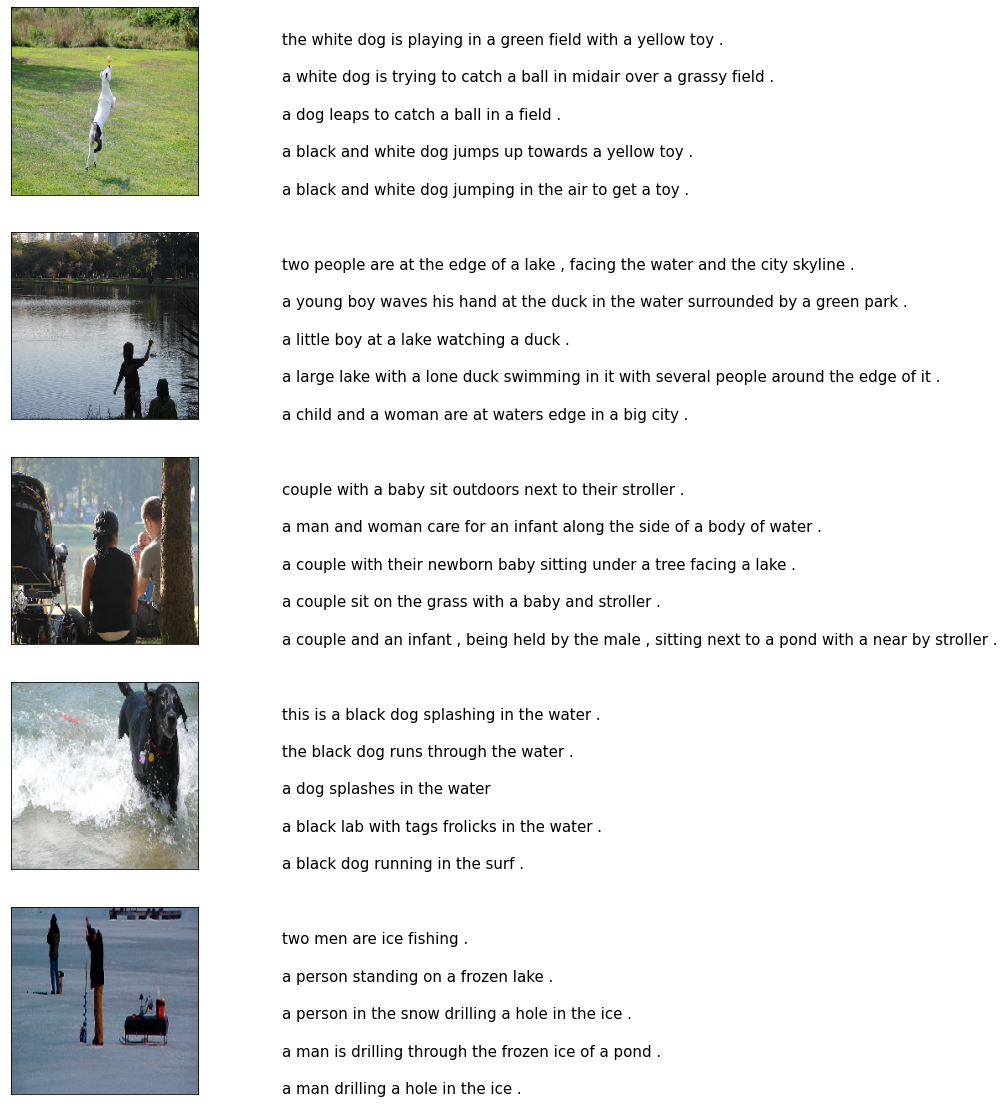

In [5]:
from keras.preprocessing.image import load_img, img_to_array
npic = 5  # No. of Pictures
npix = 224  # No. of Pixels
target_size = (npix, npix, 3)  # Target Size of Image (224, 224, 3)
count = 1
fig = plt.figure(figsize=(10,20))  # To Plot the Image
for jpgfnm in uni_filenames[15:15+npic]:  # Taking random 5 images of Dataset
    filename = Flickr_jpg_dir + '/' + jpgfnm  # Constructing file name
    captions = list(df_txt_flickr["caption"].loc[df_txt_flickr["filename"]==jpgfnm].values)  # Finding Captions where filename matches 'jpgfnm'
    image_load = load_img(filename, target_size=target_size)  # Loads image with size as target_size
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load) # To print the Image
    count += 1
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off') # To put the axis 'off'
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)
    count += 1
plt.show()

## 4. Creating Corpus of Unique Words
### A New dataframe 'dfword' is created to visualize distribution of words. It contains each word and its frequency in the entire tokens in decreasing order as shown below.

In [6]:
def df_word(df_txt_flickr):
    vocabulary = []  # Declared an empty list vocabulary 
    for i in range(len(df_txt_flickr)):
        temp = df_txt_flickr.iloc[i,2]  #.iloc[] is from 0 to length-1 & [ ,2] is selcted for 'caption'
        vocabulary.extend(temp.split())
    print('Total Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt_flickr)
dfword.head(10)  # Returns top 5 Rows of dfword 

Total Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744
5,is,9345
6,and,8852
7,dog,8136
8,with,7765
9,man,7266


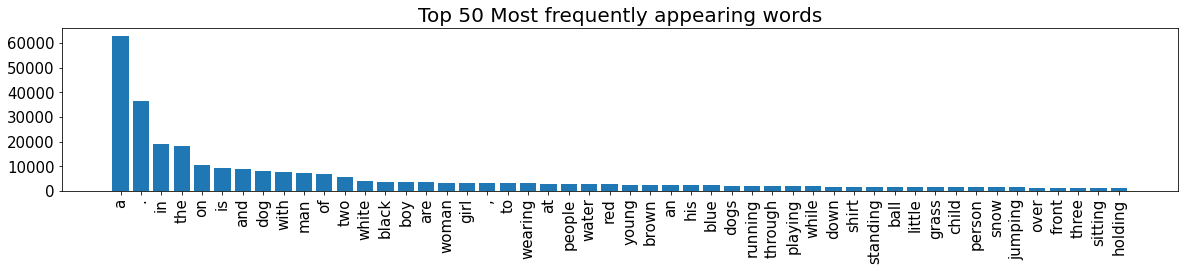

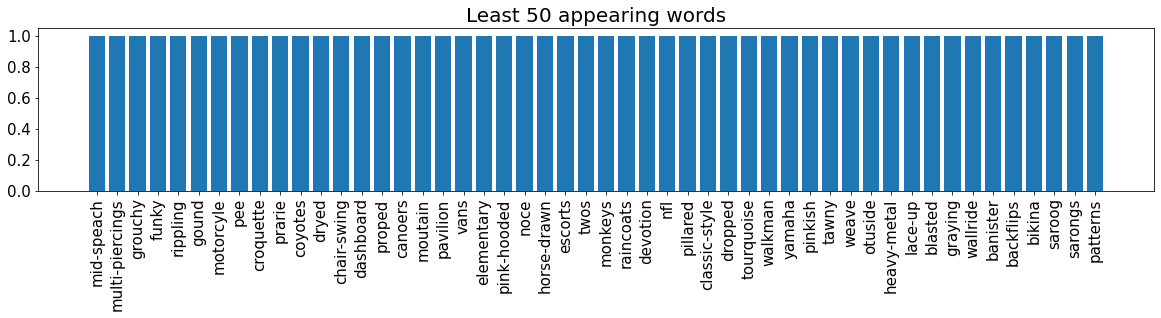

In [7]:
topn = 50  # Taking top 50 words
def plthist(dfsub, title):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=15)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=15)
    plt.title(title,fontsize=20)
    plt.show()
plthist(dfword.iloc[:topn,:],title="Top 50 Most frequently appearing words")
plthist(dfword.iloc[-topn:,:],title="Least 50 appearing words")

## 5. Data Cleaning
   ### **5.1 Removing Punctuations** 

In [8]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

### **5.2 Removing Single Characters** 

In [9]:
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

 ### **5.3 Removing Numeric Values from Captions** 

In [10]:
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

### **5.4 Cleaning Data by Calling Above f(n)s**

#### Using the above functions, we remove punctuations, single characters & numerical values as they do not contain relevant information for image captioning.

In [11]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
for i, caption in enumerate(df_txt_flickr.caption.values): 
    # enumerate() Adds a counter to an iterable & returns it as enumerate object
    newcaption = text_clean(caption)
    if(i<10): # Printing the first 10 Captions for example
        print(newcaption)
    df_txt_flickr["caption"].iloc[i] = newcaption

 child in pink dress is climbing up set of stairs in an entry way
 girl going into wooden building
 little girl climbing into wooden playhouse
 little girl climbing the stairs to her playhouse
 little girl in pink dress going into wooden cabin
 black dog and spotted dog are fighting
 black dog and tricolored dog playing with each other on the road
 black dog and white dog with brown spots are staring at each other in the street
 two dogs of different breeds looking at each other on the road
 two dogs on pavement moving toward each other


Total Vocabulary Size: 8763


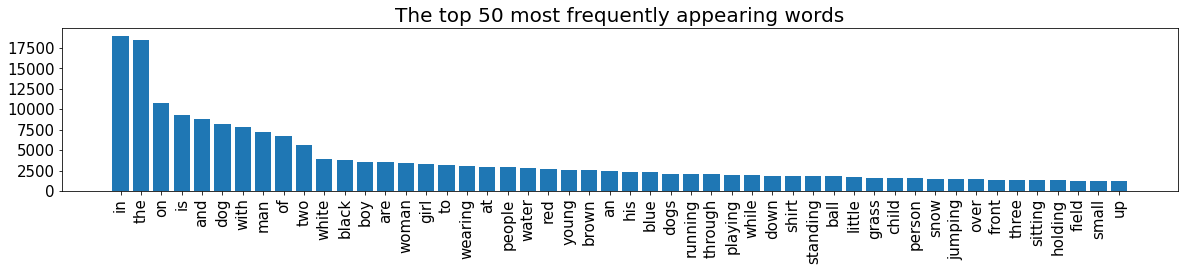

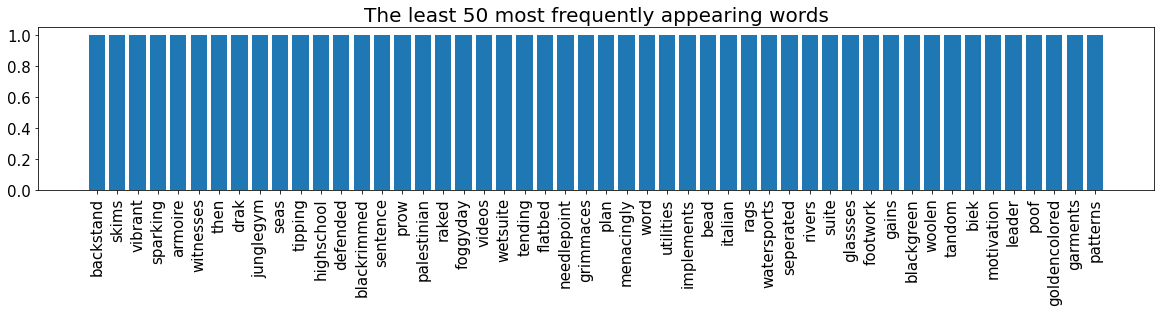

In [12]:
dfword = df_word(df_txt_flickr)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

### **5.5 Adding 'startseq' & 'endseq' to captions**

In [13]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'  # Adding <startseq> and <endseq> to all captions
        caps.append(txt)
    return(caps)
df_txt_flickr0 = copy(df_txt_flickr)
df_txt_flickr0["caption"] = add_start_end_seq_token(df_txt_flickr["caption"])
df_txt_flickr0.head(5)
del df_txt_flickr

## 6. VGG-16 (Trained on ImageNet)
### Using VGG-16 Net Pre-trained on ImageNet (Convolutional Neural Network).

In [14]:
from keras.applications import VGG16  # Importing VGG-16 Net from keras.applications
modelvgg = VGG16(include_top=True,weights=None)
modelvgg.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5") # Loading Pre-Trained Wts of VGG-16 on ImageNet
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 7. VGG-16 Net as Feature Extractor
### The 'predictions(Dense)' i.e., the output layer of the above VGG-16 Net contains 1000 o/p's as it was used for classification on 1000 different classes. But since we are using VGG-16 Net as a Feature Extractor in Transfer Learning, we will remove the last layer (i.e., the one used in classification). This Net takes an image of size (224, 224, 3).

In [15]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output) # Removing Last Layer of VGG-16 Pretrained Net
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 8. Extracting Features from Flickr8k Images

In [16]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()  # To preserve the Order of Dictionary Keys
npix = 224  # No. of Pixels 
target_size = (npix,npix,3)  # Target Size of the Image
for i,name in enumerate(jpgs):
    filename = Flickr_jpg_dir + '/' + name  # Load an image from file
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)  # Convert the image pixels to a Numpy Array
    nimage = preprocess_input(image)
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3])) 
    images[name] = y_pred.flatten()

## 9. Data Preprocessing

In [17]:
dimages, keepindex = [],[]
nd=(df_txt_flickr0["index"].values)
b = [(int(i)==0) for i in nd]
df_txt_flickr0 = df_txt_flickr0.loc[df_txt_flickr0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt_flickr0.filename):  # enumerate() adds a counter to an iterable & returns an enumerate object
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt_flickr0["filename"].iloc[keepindex].values
dcaptions = df_txt_flickr0["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_txt_flickr0["index"][:5])

0     0
5     0
10    0
15    0
20    0
Name: index, dtype: object


### Using Tokenizer to change Character Vector to Integer Vector

In [18]:
from keras.preprocessing.text import Tokenizer
count_words=22000  # Maximum no. of words in dictionary 
# nb_words = 31782
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


### Splitting between Train, Validation & Test Sets

In [19]:
prop_test, prop_val = 0.2, 0.2 
N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)
def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], dtexts[Ntest:Ntest+Nval],dtexts[Ntest+Nval:])
dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

### Finding Maximum Caption Length

In [20]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [21]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))
    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)
Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


## 10. LSTM
### The LSTM Model takes 4096-Dimensional Feature Vector from the above VGG-16 Net & the Tokenized caption upto 't'th word as the input & gives 't+1' th tokenized word of the caption as the output. Given the caption prediction up to 't' th word, the model predicts the 't+1'st word, & then the input caption can be augmented with the predicted word to contain the caption up to 't+1' th word. The augmented caption up to 't+1' st word can, in turn, be used as input to predict 't+2' nd word in caption. The process is repeated until 'endseq' is predicted.

In [22]:
from keras import layers
print(vocab_size)  # Image feature

dim_embedding = 64
input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

# Sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

# Combined Model for Decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding[0][0]                  
_______________________________________________________________________________________

### The Model is as plotted below:

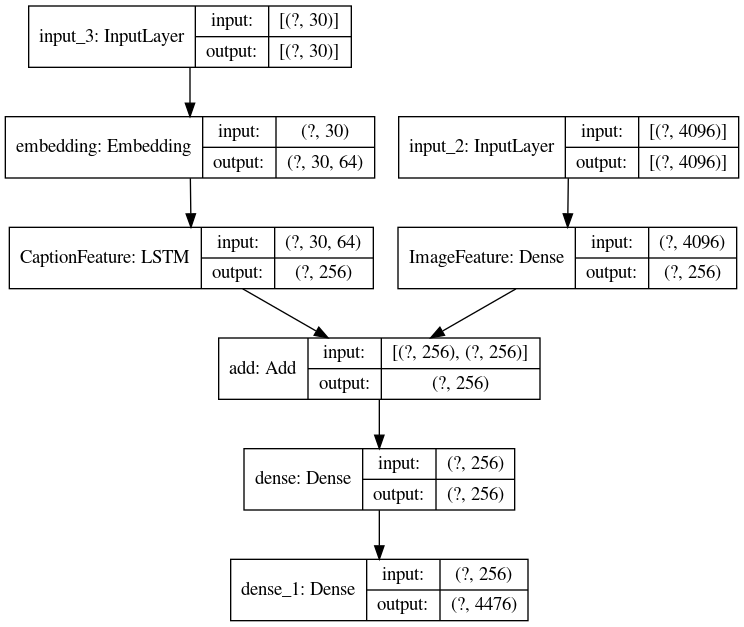

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model3.png', show_shapes=True)

## 11. Training the LSTM Model

### The Model is trained on the Training Set with epochs = 7 & batch size = 64

In [24]:
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=7, verbose=2, batch_size=64, validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

Epoch 1/7
776/776 - 70s - loss: 5.3446 - val_loss: 4.8287
Epoch 2/7
776/776 - 68s - loss: 4.3673 - val_loss: 4.4971
Epoch 3/7
776/776 - 69s - loss: 3.8976 - val_loss: 4.3913
Epoch 4/7
776/776 - 69s - loss: 3.5792 - val_loss: 4.4714
Epoch 5/7
776/776 - 69s - loss: 3.3093 - val_loss: 4.6247
Epoch 6/7
776/776 - 70s - loss: 3.0608 - val_loss: 4.7514
Epoch 7/7
776/776 - 69s - loss: 2.8247 - val_loss: 4.9503
TIME TOOK 8.19MIN
(49631, 4096) (49631, 30) (49631, 4476)


## 12. Plotting Loss & Validation Loss 
### Training Data Overfits the Validation Set Data easily since we are using the Fickr 8k Dataset (due to computation limits) which is a small dataset for Image Captioning in comparision to other larger datasets like Flickr30k & MS-COCO.

Plotting Loss & Validation Loss:


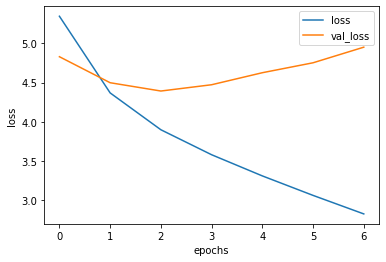

In [25]:
print('Plotting Loss & Validation Loss:')
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## 13. Predicting Captions for Test Set

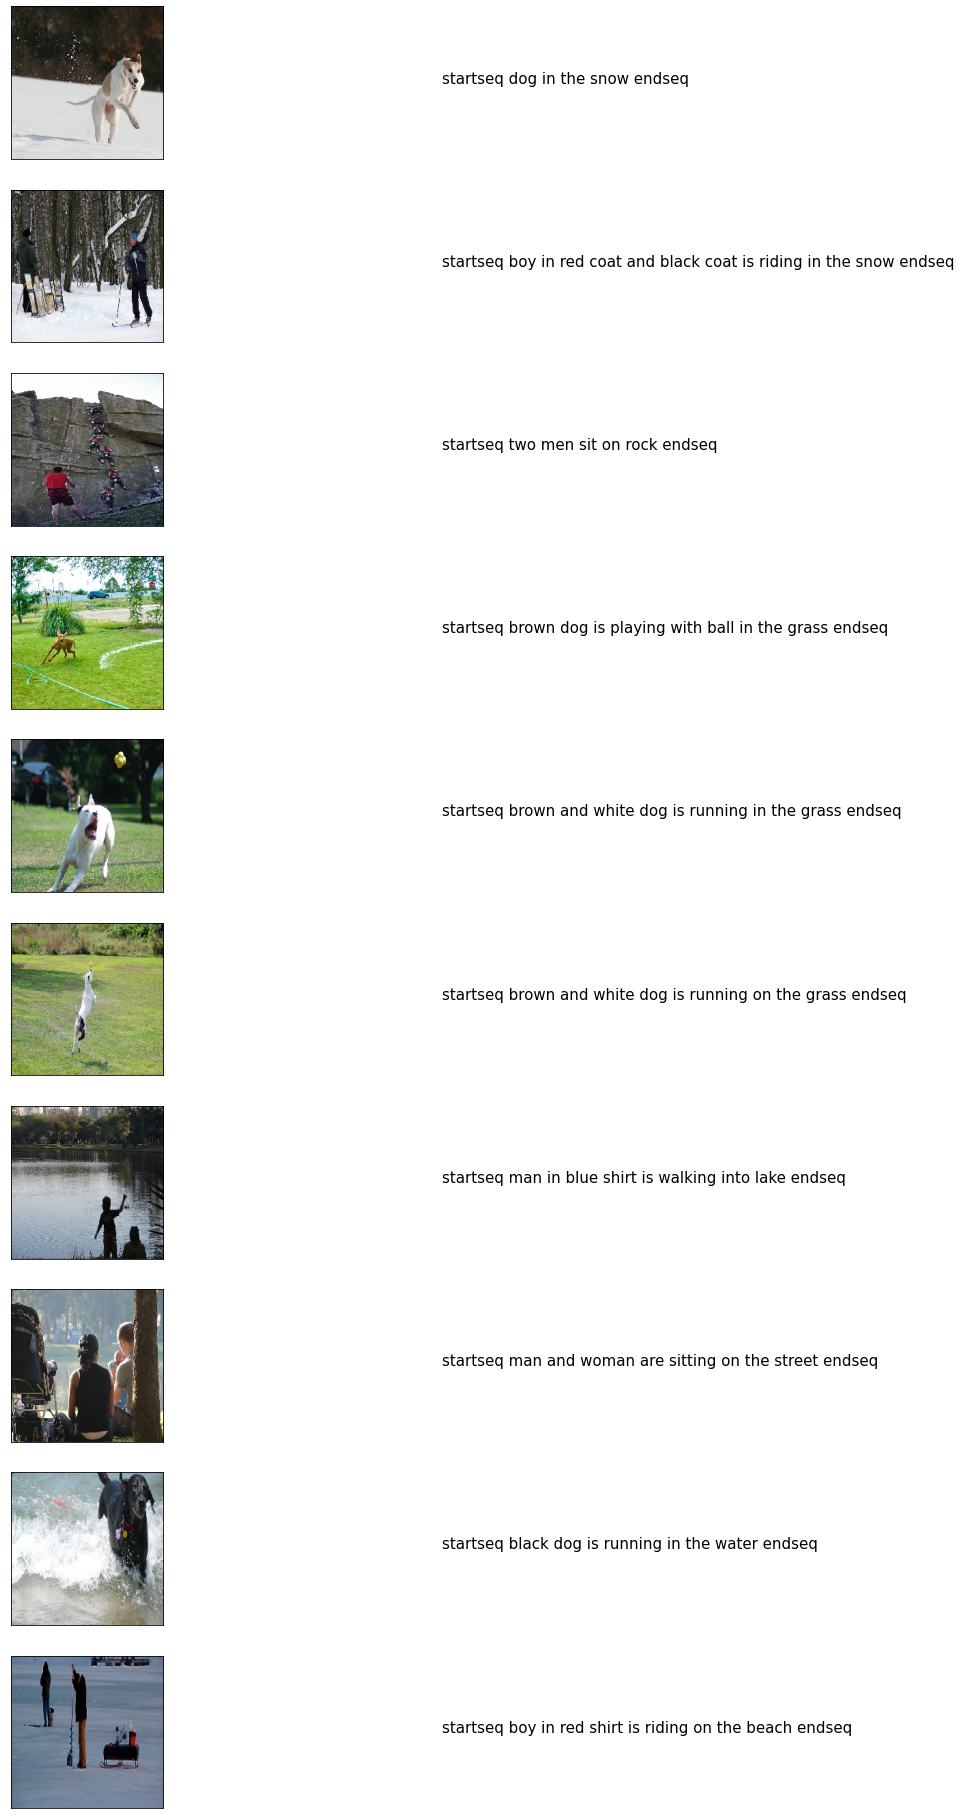

In [38]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
fig = plt.figure(figsize=(20,50))
for jpgfnm, image_feature in zip(fnm_test[npic+5:npic+15],di_test[npic+5:npic+15]):
    
    filename = Flickr_jpg_dir + '/' + jpgfnm # Images
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic+10,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    caption = predict_caption(image_feature.reshape(1,len(image_feature))) # Captions
    ax = fig.add_subplot(npic+10,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=15)
    count += 1

plt.show()

## 14. Finding BLEU Score

In [27]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] # Removing startreg & endreg
    
    # Captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1] # Removing startreg & endreg
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
        
print("The Mean BLEU Value for the Test Set is {:4.3f}".format(np.mean(bleus)))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
The Mean BLEU Value for the Test Set is 0.381


## 15. Images with Low & High BLEU Score in Test Set 

Captions corresponding to Low-BLEU Score


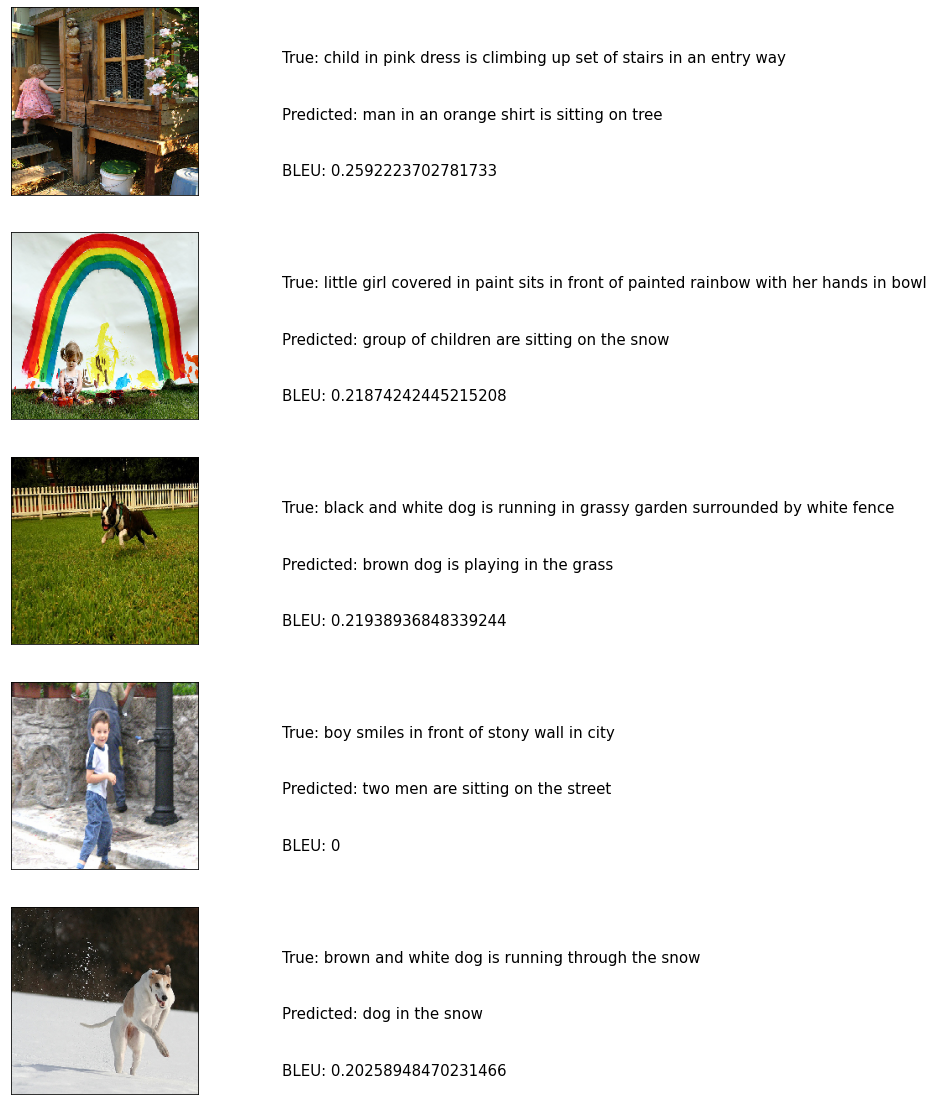

Captions corresponding to High-BLEU Score


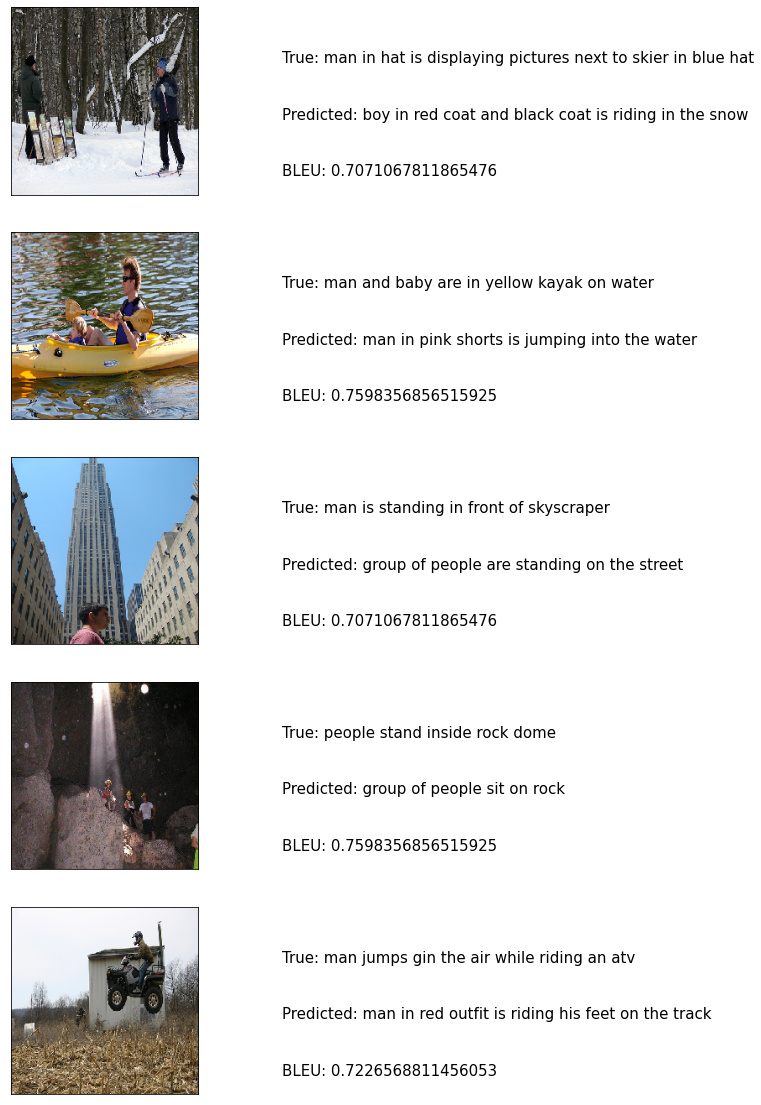

In [28]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        filename = Flickr_jpg_dir + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"True:" + caption_true,fontsize=15)
        ax.text(0,0.4,"Predicted:" + caption,fontsize=15)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=15)
        count += 1
    plt.show()

print("Captions corresponding to Low-BLEU Score")
plot_images(pred_bad)
print("Captions corresponding to High-BLEU Score")
plot_images(pred_good)

## 16. Application (& Testing on Self-Made Data)
### Testing the Neural Image Caption (NIC) Generator on some random images captured by Devices used for Aiding the Visually Impaired People.

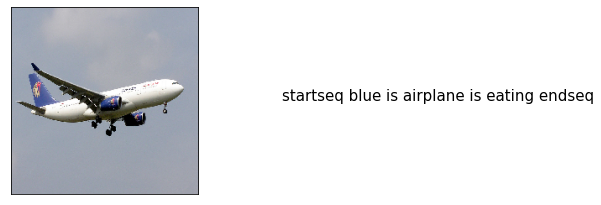

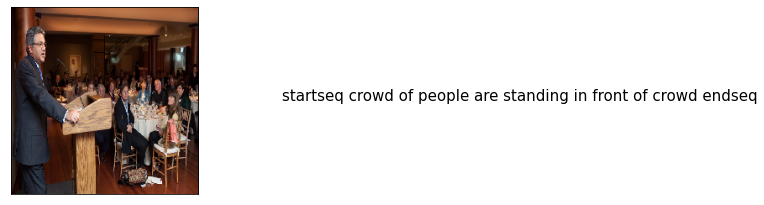

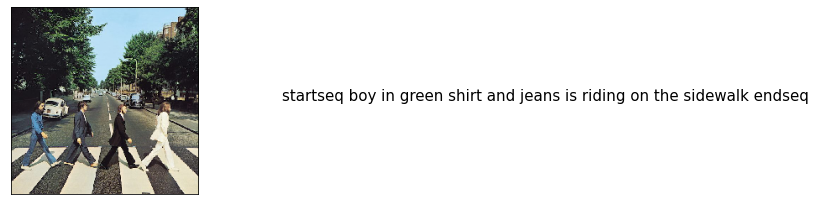

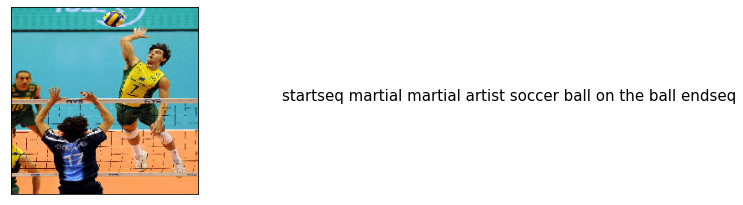

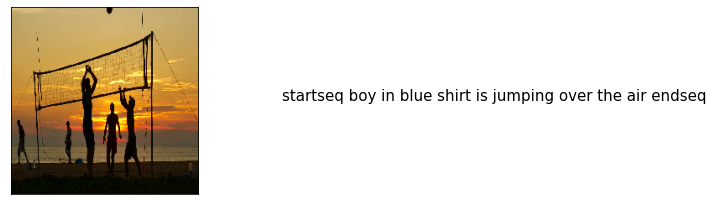

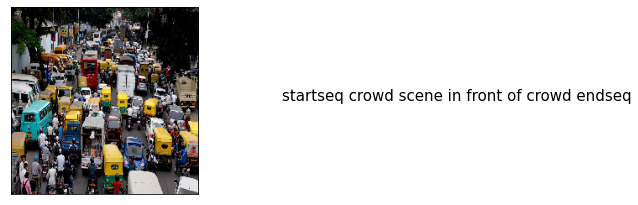

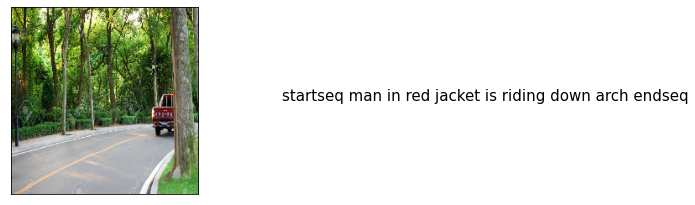

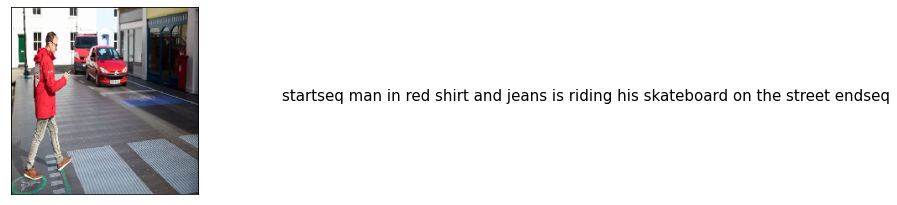

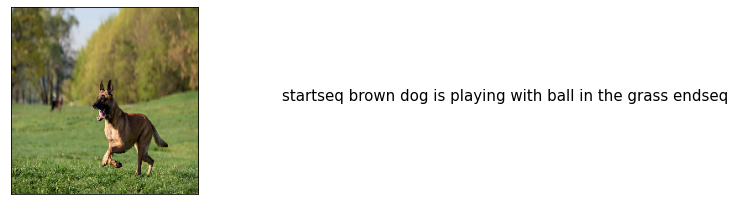

In [40]:
def Aiding_Visually_Impaired(filename):
       
    def predict_caption(image):
        '''
        image.shape = (1,4462)
        '''

        in_text = 'startseq'
        for iword in range(maxlen):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence],maxlen)
            yhat = model.predict([image,sequence],verbose=0)
            yhat = np.argmax(yhat)
            newword = index_word[yhat]
            in_text += " " + newword
            if newword == "endseq":
                break
        return(in_text)

    npic = 5
    npix = 224
    target_size = (npix,npix,3)
    count = 1
    fig = plt.figure(figsize=(10,20))

    # Images 
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)  # Convert the image pixels to a Numpy Array
    n_image = preprocess_input(image)
    Self_made_img = modelvgg.predict(n_image.reshape( (1,) + n_image.shape[:3])) 
    image_ = Self_made_img.flatten();
    
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    # Captions
    caption = predict_caption(image_.reshape(1,len(image_)))

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=15)
    count += 1

    plt.show()
    
    
Aiding_Visually_Impaired('../input/test-set/Image_1.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_2.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_3.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_4.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_5.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_6.jpeg')
Aiding_Visually_Impaired('../input/test-set/Image_7.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_8.jpg')
Aiding_Visually_Impaired('../input/test-set/Image_9.jpg')

## Conclusion

### Thus the Deep Neural Image Caption Generator (NIC) was made successfully. This model can be used in Devices for Visually Impaired People. Further work include, increasing the BLEU Score & the Accuracy of the Model & Embedding it for real-time web/ app applications for use.